<div>
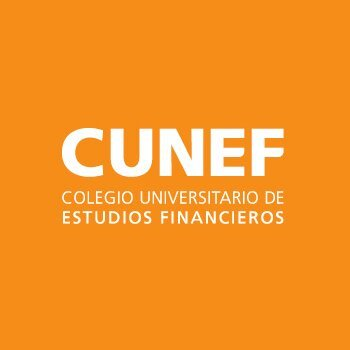
</div>

# **Número de vuelos de mercancías en España**

## *Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del csv y preparación de los datos*

Se procede a la lectura del CSV del tráfico aéreo en España, ofrecidos por AENA.
- Fuente: https://www.aena.es/es/estadisticas/inicio.html

In [3]:
df_vuelos = pd.read_excel("vuelos.xlsx")
df_vuelos = df_vuelos.set_index("Periodo")
df_vuelos

,Total Pasajeros,Total Mercancías
Periodo,,
2014-01-01,10959721,51279738
2014-02-01,10779086,51395821
2014-03-01,13446155,60074235
2014-04-01,16246439,55234845
2014-05-01,17540838,56289587
...,...,...
2022-02-01,11908046,78764432
2022-03-01,15587273,92308548
2022-04-01,20458260,82681716


In [4]:
df_vuelos=df_vuelos.drop('Total Pasajeros', axis=1)
df_vuelos

,Total Mercancías
Periodo,
2014-01-01,51279738
2014-02-01,51395821
2014-03-01,60074235
2014-04-01,55234845
2014-05-01,56289587
...,...
2022-02-01,78764432
2022-03-01,92308548
2022-04-01,82681716


## *Graficación de la serie temporal*

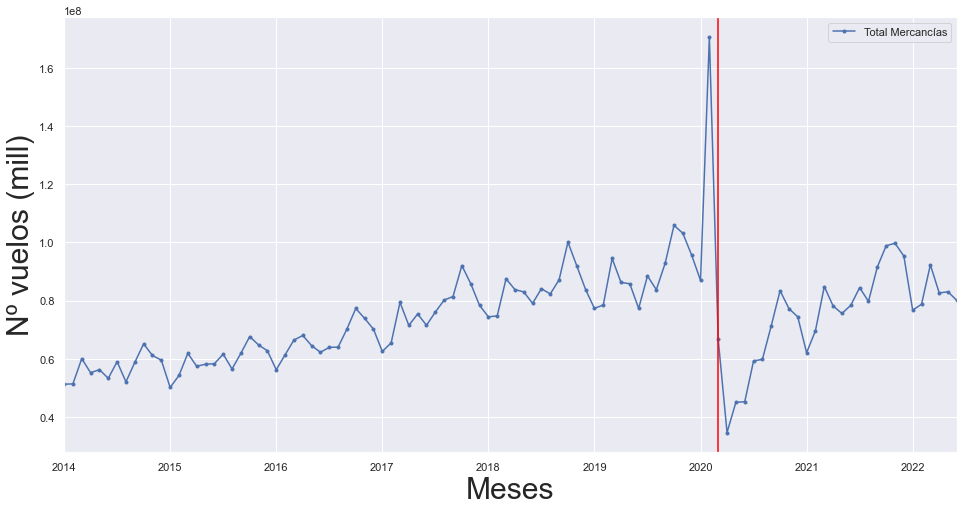

In [5]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(16,8)})
fig = df_vuelos.plot(marker='.') 
fig.set_ylabel('Nº vuelos (mill)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

En común podemos apreciar que existía una tendencia creciente hasta la época COVID, en la que se redujeron el número de vuelos tanto en pasajeros como en mercancías, en cambio parece estar recuperando los números. 

Por otra parte, en el total de pasajeros se puede apreciar una clara estacionalidad marcada por los meses de verano, fechas en las que hay mucha gente que se mueve a otros lugares para pasar las vacaciones. Para el total de mercancías se irá viendo a lo largo de los siguientes ploteos. 


A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza tanto de pasajeros como de mercancías
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [6]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [7]:
media=split_and_summarize(df_vuelos,'Total Mercancías',4,np.mean)
varianza=split_and_summarize(df_vuelos,'Total Mercancías',4,np.var)

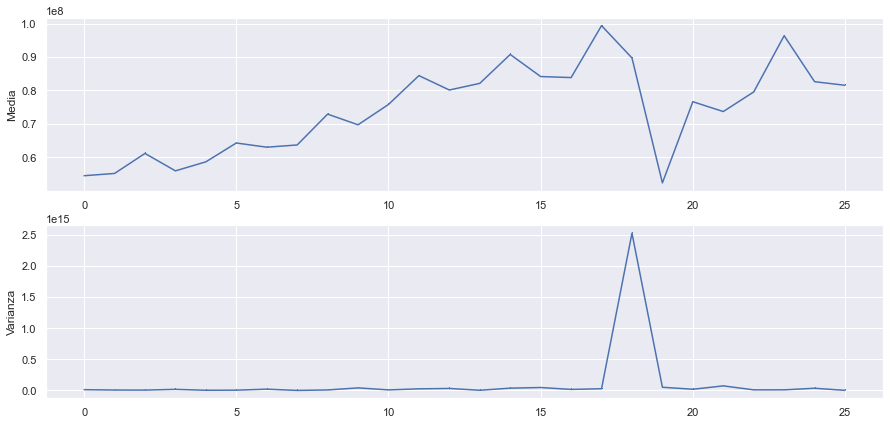

In [8]:
cols=['media','varianza']
df=pd.DataFrame([media,varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

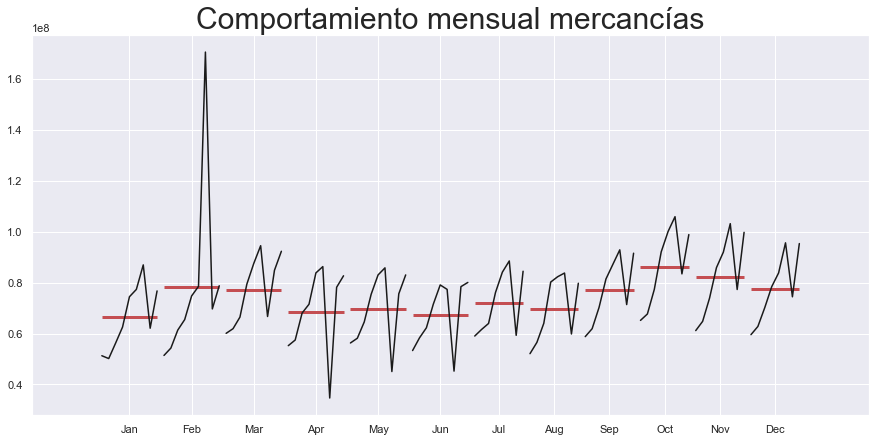

In [8]:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_vuelos['Total Mercancías'], ax = ax)
ax.set_title('Comportamiento mensual mercancías', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

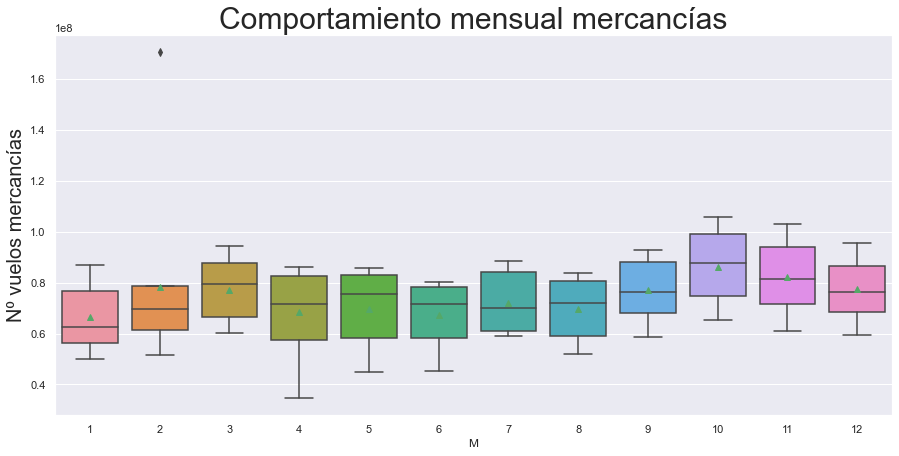

In [10]:
df_vuelos['M'] = df_vuelos.index.month
sns.boxplot(data = df_vuelos, x = 'M', y='Total Mercancías', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Nº vuelos mercancías', fontsize = 20)
ax.set_title('Comportamiento mensual mercancías', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

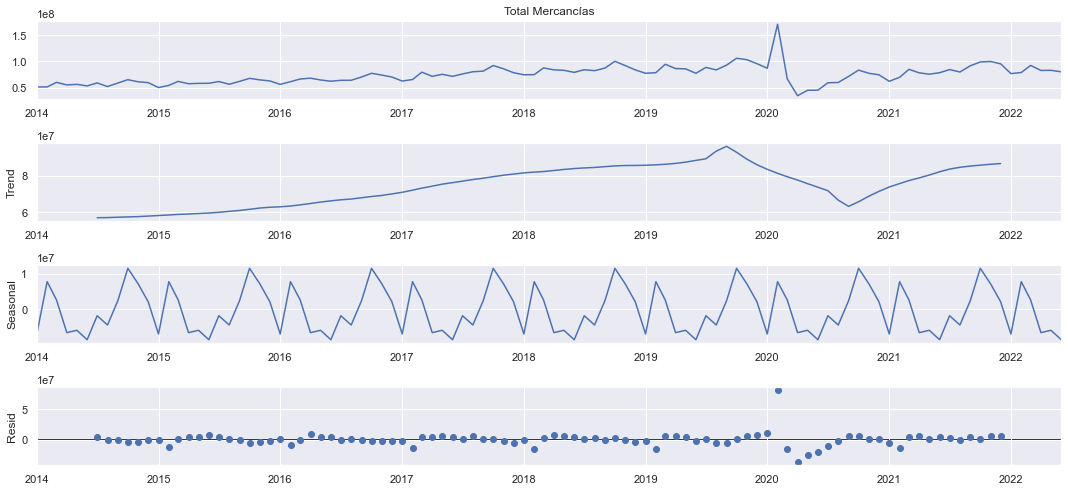

In [9]:
desglose_mercancias = seasonal_decompose(df_vuelos['Total Mercancías'], 
                                   model='additive', 
                                   period=12);
desglose_mercancias.plot();